# Spectrogram Creation Using GPU

The main goal of this notebook is to create spectrograms more quickly using GPUs. I encountered this problem when trying to create and optimize new spectrograms for the competition. However, the more features I added, like bandpass filters, notch filters, etc., the longer it took to create the spectrograms, making experimentation very difficult. It could take over 2 hours to generate the spectrograms.

In this notebook, I demonstrate how using a GPU can reduce the time to create spectrograms to approximately 30 minutes with acceptable quality. It's possible to improve the quality by adjusting parameters (nperseg, noverlap, nfft), thereby facilitating experimentation for creating better spectrograms.

My main goal was to create spectrograms that visually resemble as closely as possible the spectrograms used by experts for classifying competition categories.

As shown in the competition data below, there is an image of how the data was classified by experts:

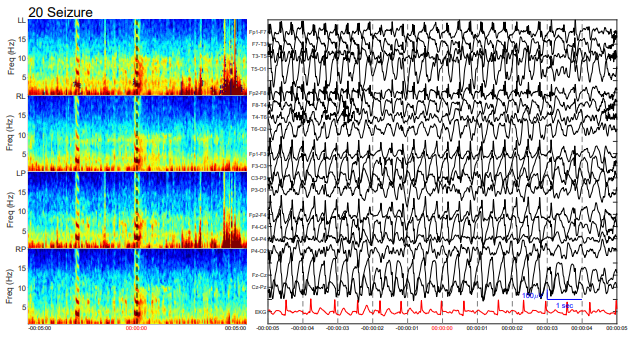

On the left side, we have spectrograms with 10 minutes of data, and the central point highlighted with a black line represents the 10 seconds of EEG data plotted as signals on the right side.

This notebook has been greatly enhanced by the inspiring work of Chris Deotte. I used his tutorial on [creating spectrograms from EEG](https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg) and leveraged the [Rapids dataset](https://www.kaggle.com/datasets/cdeotte/rapids) available to optimize signal processing with cuSignal. A special thank you to @cdeotte for sharing these valuable resources with the community, significantly facilitating the development of this notebook.

# Interesting update
Optimized spectogram image creation using 3 different spectogram types using different times, the spectogram improved my LB result, possibly it can improve yours :)

1. Spec provided by the competition: 10 minutes of data.
2. Custom Spec 1: 50 seconds of data (Zoom in the inference window).
3. Custom Spec 2: 10 seconds of data (Even larger zoom in the inference window).

These three spectrograms were combined into a single 512x512 pixel spectrogram, optimizing the data representation for the model training. Here is the link to the dataset that contains the custom spectrogram; please give an upvote if you appreciate the work!

NOTE: Process takes more than 1 hour

Notebook with LB 0.37 using these spectograms - https://www.kaggle.com/code/rafaelzimmermann1/lb-0-37-without-ensemble-using-label-refinement 


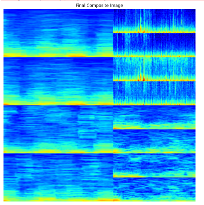

In [ ]:
# Details About the GPU Used
!nvidia-smi

##### Installation of RAPIDS to Use cuSignal

In [ ]:
%%time
# Installation of RAPIDS to Use cuSignal
import sys

!cp ../input/rapids/rapids.0.17.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
!rm /opt/conda/envs/rapids.tar.gz

sys.path += ["/opt/conda/envs/rapids/lib/python3.7/site-packages"]
sys.path += ["/opt/conda/envs/rapids/lib/python3.7"]
sys.path += ["/opt/conda/envs/rapids/lib"]
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

##### create_spectrogram_with_cusignal

In [ ]:
import cupy as cp
import cusignal
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt, iirnotch
import os
import cv2
from tqdm import tqdm

def create_spectrogram_with_cusignal(eeg_data, eeg_id, start, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 30,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 4):
    
    electrode_names = ['LL', 'RL', 'LP', 'RP']

    electrode_pairs = [
        ['Fp1', 'F7', 'T3', 'T5', 'O1'],
        ['Fp2', 'F8', 'T4', 'T6', 'O2'],
        ['Fp1', 'F3', 'C3', 'P3', 'O1'],
        ['Fp2', 'F4', 'C4', 'P4', 'O2']
    ]
    
    # Filter specifications
    nyquist_freq = 0.5 * 200
    low_cut_freq_normalized = low_cut_freq / nyquist_freq
    high_cut_freq_normalized = high_cut_freq / nyquist_freq

    # Bandpass and notch filter
    bandpass_coefficients = butter(order_band, [low_cut_freq_normalized, high_cut_freq_normalized], btype='band')
    notch_coefficients = iirnotch(w0=60, Q=30, fs=200)
    
    spec_size = duration * 200
    start = start * 200
    real_start = start + (10_000//2) - (spec_size//2)
    eeg_data = eeg_data.iloc[real_start:real_start+spec_size]
    
    
    # Spectrogram parameters
    fs = 200
    nperseg = nperseg_ 
    noverlap = noverlap_ 
    nfft = nfft_
    
    if spec_size_freq <=0 or spec_size_time <=0:
        frequencias_size = int((nfft // 2)/5.15198)+1
        segmentos = int((spec_size - noverlap) / (nperseg - noverlap)) 
    else:
        frequencias_size = spec_size_freq
        segmentos = spec_size_time
        
    # Initialize spectrogram container
#     print(frequencias_size, segmentos)
    spectrogram = cp.zeros((frequencias_size, segmentos, 4), dtype='float32')
    
    processed_eeg = {}

    for i, name in enumerate(electrode_names):
        cols = electrode_pairs[i]
        processed_eeg[name] = np.zeros(spec_size)
        for j in range(4):
            # Compute differential signals
            signal = cp.array(eeg_data[cols[j]].values - eeg_data[cols[j+1]].values)

            # Handle NaNs
            mean_signal = cp.nanmean(signal)
            signal = cp.nan_to_num(signal, nan=mean_signal) if cp.isnan(signal).mean() < 1 else cp.zeros_like(signal)
            
            # Filter bandpass and notch
            signal_filtered = filtfilt(*notch_coefficients, signal.get())
            signal_filtered = filtfilt(*bandpass_coefficients, signal_filtered)
            signal = cp.asarray(signal_filtered)
            
            # GPU-accelerated spectrogram computation
            frequencies, times, Sxx = cusignal.spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

            # Filter frequency range
            valid_freqs = (frequencies >= 0.59) & (frequencies <= 20)
            frequencies_filtered = frequencies[valid_freqs]
            Sxx_filtered = Sxx[valid_freqs, :]

            # Logarithmic transformation and normalization using Cupy
            spectrogram_slice = cp.clip(Sxx_filtered, cp.exp(-4), cp.exp(6))
            spectrogram_slice = cp.log10(spectrogram_slice)

            normalization_epsilon = 1e-6
            mean = spectrogram_slice.mean(axis=(0, 1), keepdims=True)
            std = spectrogram_slice.std(axis=(0, 1), keepdims=True)
            spectrogram_slice = (spectrogram_slice - mean) / (std + normalization_epsilon)
            
            spectrogram[:, :, i] += spectrogram_slice
            processed_eeg[f'{cols[j]}_{cols[j+1]}'] = signal.get()
            processed_eeg[name] += signal.get()
        
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        if mean_montage_names > 0:
            spectrogram[:,:,i] /= mean_montage_names

    # Convert to NumPy and apply Gaussian filter
    spectrogram_np = cp.asnumpy(spectrogram)
    if sigma_gaussian > 0.0:
        spectrogram_np = gaussian_filter(spectrogram_np, sigma=sigma_gaussian)

    # Filter EKG signal
    ekg_signal_filtered = filtfilt(*notch_coefficients, eeg_data["EKG"].values)
    ekg_signal_filtered = filtfilt(*bandpass_coefficients, ekg_signal_filtered)
    processed_eeg['EKG'] = np.array(ekg_signal_filtered)

    return spectrogram_np, processed_eeg

##### Function to create training data

In [ ]:
import pandas as pd

# Function to create training data
def create_train_data():
    path = '/kaggle/input/hms-harmful-brain-activity-classification/'
    classes = [
        "seizure_vote", "lpd_vote", "gpd_vote", 
        "lrda_vote", "grda_vote", "other_vote"
    ]
    df = pd.read_csv(f'{path}train.csv')
    
    # Create a new identifier combining multiple columns
    id_cols = ['eeg_id', 'spectrogram_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    df['new_id'] = df[id_cols].astype(str).agg('_'.join, axis=1)
    
    df['sum_votes'] = df[classes].sum(axis=1)
    grouped_df = df.groupby('new_id').agg({
        'eeg_id': 'first',
        'eeg_label_offset_seconds': ['min', 'max'],  
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'spectrogram_id': 'first',
        'patient_id': 'first',
        'expert_consensus': 'first',
        'seizure_vote': 'first',
        'lpd_vote': 'first',
        'gpd_vote': 'first',
        'lrda_vote': 'first',
        'grda_vote': 'first',
        'other_vote': 'first',
        'sum_votes': 'first',
    }).reset_index()

    # Post-aggregation processing to adjust column names.
    new_column_names = []
    for col in grouped_df.columns:
        if isinstance(col, tuple):
            # For aggregated columns with multiple functions, add the function suffix to the column name.
            new_column_names.append(f"{col[0]}_{col[1]}" if col[1] else col[0])
        else:
            new_column_names.append(col)
    
    grouped_df.columns = new_column_names
    
    # Removing "_first" from the column names.
    grouped_df.columns = [col.replace('_first', '') for col in grouped_df.columns]
    
    return grouped_df

train_df = create_train_data()
display(train_df)

One of the best methods I found for visualizing the new spectrograms was by comparing them with the spectrograms provided by the competition for the same period, i.e., viewing the same 50 seconds in the spectrogram that were used by the EEG to create the new spectrogram. On the right side, I placed the EEG data for a more appropriate review of what was happening. Below is an example of how it turned out.

In [ ]:
def normalize_signal_half_amplitude(reference_signal, signal_to_normalize):
    # Calculate the maximum amplitude of the signals
    reference_amplitude = np.max(reference_signal) - np.min(reference_signal)
    amplitude_to_normalize = np.max(signal_to_normalize) - np.min(signal_to_normalize)
    
    # Check if the amplitude to normalize is zero
    if amplitude_to_normalize == 0:
        # Avoid division by zero and set scale factor to zero or an appropriate value
        scale_factor = 0
    else:
        # Adjust the scale factor so the amplitude of the normalized signal is half of the reference amplitude
        scale_factor = 0.5 * reference_amplitude / amplitude_to_normalize
    
    # Normalize the second signal
    normalized_signal = signal_to_normalize * scale_factor

    return normalized_signal

def plot_eeg_channels_montage(eeg_data, fig, gs, start_sec=None, duration_sec=None, sampling_rate=200, combined='not'):

    if start_sec is not None and duration_sec is not None:
        start_idx = 0
        end_idx = start_idx + int(duration_sec * sampling_rate)

    fig.add_subplot(gs[:, 2:])
    offset = 0
    if combined == 'montage':
        average_signal = np.zeros(end_idx - start_idx)
        for i, col in enumerate(eeg_data):
            if col == "EKG":
                continue
            if i > 0:
                offset -= 75
            plt.plot(range(end_idx - start_idx), eeg_data[col][start_idx:end_idx] + offset, color='black', linewidth=0.8)
            plt.text(-0.01, offset, col, ha='right', va='center', transform=plt.gca().get_yaxis_transform())
            if ((i + 1) % 5 == 0):
                offset -= 125
            average_signal += eeg_data[col][start_idx:end_idx]
        average_signal /= 10
        
        offset -= 50
        eeg_data['EKG'] = normalize_signal_half_amplitude(average_signal, eeg_data['EKG'])
        plt.plot(range(end_idx - start_idx), eeg_data['EKG'][start_idx:end_idx] + offset, color='red', linewidth=0.8)
        plt.text(-0.01, offset, 'EKG', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
        
    plt.xlim(0, end_idx - start_idx)
    plt.yticks([])
    plt.axvline(x=(end_idx - start_idx) // 2, color='1', linestyle='--', linewidth=2)

    return fig

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pandas as pd

def visualize_eeg_spectrogram_comparison(df, index, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 30,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 4):
    row = df.iloc[index]
    highest_vote = f"{row['expert_consensus'].lower()}_vote"
    display(f"EEG ID {row['eeg_id']} Sum of votes: {row['sum_votes']} Expert Consensus: {row['expert_consensus']}: {row[highest_vote]} EEG {row['eeg_label_offset_seconds_min']} Spec {row['spectrogram_label_offset_seconds_min']}")
    
    print('1- Competition Spectrogram 2- Custom EEG Spectrogram 3- EEG Data')
    
    spec_id = row['spectrogram_id']
    spec = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/{spec_id}.parquet')
    eeg_id = row['eeg_id']
    eeg = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet')

    seconds = row['eeg_label_offset_seconds_min'] + 20
    middle_spec = ((row['spectrogram_label_offset_seconds_min']) // 2) + 150
    
    # Custom spectrogram creation
    
    img_spec, new_eeg = create_spectrogram_with_cusignal(eeg, eeg_id, int(row['eeg_label_offset_seconds_min']),duration, 
                                    low_cut_freq, high_cut_freq, order_band,
                                    spec_size_freq, spec_size_time,
                                    nperseg_, noverlap_, nfft_,
                                    sigma_gaussian, 
                                    mean_montage_names)
    
    # Segment data
    segments = ['LL', 'RL', 'LP', 'RP']
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(4, 3)
    axs = [fig.add_subplot(gs[i, 0]) for i in range(len(segments))]
    
    # Large subplot for montage
    fig = plot_eeg_channels_montage(new_eeg, fig, gs, start_sec=int(row['eeg_label_offset_seconds_min']), duration_sec=duration, combined='montage')
    
    img_spec = img_spec[::-1]
    for k in range(4):  # 4 images to plot
        ax = fig.add_subplot(gs[k, 1])
        ax.imshow(img_spec[:, :, k], aspect='auto', cmap='jet')
        ax.axvline(x=len(img_spec[0]) // 2, color='black', linestyle='--', linewidth=1)
        ax.set_yticks(np.linspace(0, len(img_spec), 6))
        ax.set_yticklabels(np.linspace(20, 0, 6))
        ax.set_ylabel(segments[k])

    for i, seg in enumerate(segments):
        cols = [col for col in spec if col.startswith(seg)]
        img = spec[cols].values.T[::-1]  # Transpose and reverse order
        
        middle_spec = int(middle_spec)
        start = int(middle_spec - 12)
        end = int(middle_spec + 12)
        img = img[:, start:end]

        # Log transform and normalize
        img = np.clip(img, np.exp(-4), np.exp(6))
        img = np.log(img)
        eps = 1e-6
        img_mean = img.mean()
        img_std = img.std()
        img = (img - img_mean) / (img_std + eps)
        
        # Plot current segment spectrogram
        axs[i].imshow(img, aspect='auto', cmap='jet')
        axs[i].set_ylabel(seg)
        axs[i].set_yticks(np.linspace(0, 100, 6))
        axs[i].set_yticklabels(np.linspace(20, 0, 6))
        axs[i].axvline(x=len(img[0]) // 2, color='black', linestyle='--', linewidth=1)
    
    fig.tight_layout(pad=0.1)
    plt.subplots_adjust(hspace=0.1)
    plt.show()



##### Cases in which the EEG spects were very similar to the spects offered in the competition (It's difficult to say because it was done in the eye, but an average of 90% of the cases were very similar)

In [ ]:
similar_cases_list = [1058173302, 1830813584, 2765359718, 3524084169, 4006310258]

filtered_cases = train_df[train_df['eeg_id'].isin(similar_cases_list)]
for i in range(len(filtered_cases)):
    visualize_eeg_spectrogram_comparison(filtered_cases, i, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 99, spec_size_time = 32,
                                    nperseg_ = 500, noverlap_ = 200, nfft_ = 1024,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 0.0)

##### Case red frequency tornado in Competition Spectrogram but not in eeg
Hard to say the proportion, I would say 1 to 2% at most
Seems like a special way to treat artifacts, or a missing bad channel filter

In [ ]:
red_tornado_cases = [2088807520, 338161210]
filtered_cases = train_df[train_df['eeg_id'].isin(red_tornado_cases)]
for i in range(len(filtered_cases)):
    visualize_eeg_spectrogram_comparison(filtered_cases, i, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 99, spec_size_time = 32,
                                    nperseg_ = 500, noverlap_ = 200, nfft_ = 1024,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 0.0)

##### Case Competition Spectrogram is empty
Hard to estimate the proportion, but I would say 1 to 2%
Attempted to create a logic, the only one I found was having a large null space, say more than 20%

In [ ]:
null_cases_list = [3030710864, 1379952459]
filtered_cases = train_df[train_df['eeg_id'].isin(null_cases_list)]
for i in range(len(filtered_cases)):
    visualize_eeg_spectrogram_comparison(filtered_cases, i, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 99, spec_size_time = 32,
                                    nperseg_ = 500, noverlap_ = 200, nfft_ = 1024,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 0.0)

##### Case of bad channel untreated equal competition on eeg
A common case of discrepancy, very hard to estimate the proportion, but I would say more than 5%
In this case, we observe a bad channel, artifact, or noise contamination, most likely due to a missing filter
or proper handling of the bad channel, which I was unable to determine

In [ ]:
bad_channel_list = [1317431280, 1476988697, 1626483520]
filtered_cases = train_df[train_df['eeg_id'].isin(bad_channel_list)]
for i in range(len(filtered_cases)):
    visualize_eeg_spectrogram_comparison(filtered_cases, i, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 99, spec_size_time = 32,
                                    nperseg_ = 500, noverlap_ = 200, nfft_ = 1024,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 0.0)

The loop iterates through train_df with progress displayed via tqdm, processing each EEG file to generate a new spectrogram.

In [ ]:
def create_spectogram_competition(spec_id, seconds_min):
    spec = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/{spec_id}.parquet')
    inicio = (seconds_min) // 2
    img = spec.fillna(0).values[:, 1:].T.astype("float32")
    img = img[:, inicio:inicio+300]
    
    # Log transform and normalize
    img = np.clip(img, np.exp(-4), np.exp(6))
    img = np.log(img)
    eps = 1e-6
    img_mean = img.mean()
    img_std = img.std()
    img = (img - img_mean) / (img_std + eps)
    
    return img 

In [ ]:
def create_final_image(image_50s, image_10s, image_10m):
    """Combine three images into a single final image."""
    # Initialize an empty image array for the first image composition
    single_channel_image1 = np.zeros((1068, 501))
    for i in range(4):
        start = i * 267
        end = start + 267
        single_channel_image1[start:end, :] = image_50s[:, :, i]

    # Initialize an empty image array for the second image composition
    single_channel_image2 = np.zeros((400, 291))
    for i in range(4):
        start = i * 100
        end = start + 100
        single_channel_image2[start:end, :] = image_10s[:, :, i]

    # Resize images to fit the final composition
    resized_image1 = cv2.resize(single_channel_image1, (400, 800), interpolation=cv2.INTER_AREA)
    resized_image2 = cv2.resize(single_channel_image2, (300, 400), interpolation=cv2.INTER_AREA)
    resized_image3 = cv2.resize(image_10m, (300, 400), interpolation=cv2.INTER_AREA)

    # Create the final image and place the resized images accordingly
    final_image = np.zeros((800, 700), dtype=np.float32)
    final_image[0:800, 0:400] = resized_image1
    final_image[0:400, 400:700] = resized_image2
    final_image[400:800, 400:700] = resized_image3
    final_image = final_image[::-1]  # Flip the final image vertically
    return cv2.resize(final_image, (512, 512), interpolation=cv2.INTER_AREA)

In [ ]:
def process_eegs(train_df, output_folder):
    """Process EEGs and save the final images."""
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over the EEG data frame
    for i in tqdm(range(len(train_df)), desc="Processing EEGs"):
        row = train_df.iloc[i]
        eeg_id = row['eeg_id']
        spec_id = row['spectrogram_id']
        seconds_min = int(row['spectrogram_label_offset_seconds_min'])
        start_second = int(row['eeg_label_offset_seconds_min'])
        
        # Load EEG data from file
        eeg_data = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet')
        eeg_new_key = f'{eeg_id}_{seconds_min}_{start_second}'

        # Generate spectrogram images from EEG data
        image_50s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 501,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
        image_10s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 10,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 100, spec_size_time = 291,
                                    nperseg_ = 260, noverlap_ = 254, nfft_ = 1030,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
        
        image_10m = create_spectogram_competition(spec_id, seconds_min)

        # Create the final combined image
        final_image = create_final_image(image_50s, image_10s, image_10m)
        
        # Save the final image in compressed format
        file_path = os.path.join(output_folder, f'{eeg_new_key}.npz')
        np.savez_compressed(file_path, final_image=final_image)
        
        if i < 3:  # Plot the final image for the first three iterations
            # Plotting the final image
            plt.figure(figsize=(10, 10))
            plt.imshow(final_image, cmap='jet')
            plt.title("Final Composite Image")
            plt.axis('off')
            plt.show()

In [ ]:
# process_eegs(train_df, 'images')